# Polymarket API Guide

This notebook demonstrates how to use Polymarket's APIs to fetch trading and user data.

## API Overview

Polymarket provides several APIs:
- **Gamma API**: Market metadata, events, and general market information
- **Data API**: Trading data, user activity, and positions
- **CLOB API**: Central Limit Order Book for placing orders (requires authentication)
- **Subgraph**: GraphQL interface for complex queries

Documentation: https://docs.polymarket.com/


In [3]:
# Install required packages
# Run this in terminal: pip install requests pandas polymarket-apis

import requests
import pandas as pd
import numpy as np
from datetime import datetime
import json


## 1. Gamma API - Market Data

The Gamma API provides market metadata including titles, descriptions, volumes, and more.
Base URL: https://gamma-api.polymarket.com


In [ ]:
# Fetch all markets
def get_events(active=None, closed=None, limit=100, offset=0, sort_by='start_date'):
    """
    Fetch events from Gamma API and sort by recency
    
    Parameters:
    - active: True for active markets, False for inactive
    - closed: True for closed markets, False for open
    - limit: Number of markets to return
    - offset: Pagination offset
    - sort_by: Field to sort by ('start_date', 'end_date', 'created_at', 'volume')
    """
    url = "https://gamma-api.polymarket.com/events"
    params = {
        "limit": limit,
        "offset": offset,
        "ascending": False
    }
    
    if active is not None:
        params["active"] = str(active).lower()
    if closed is not None:
        params["closed"] = str(closed).lower()
    
    response = requests.get(url, params=params)
    events = response.json()
    
    # Sort by the specified field (most recent first)
    if isinstance(events, list) and events:
        # Try to sort by different date fields that might exist
        date_fields = ['start_date_iso', 'end_date_iso', 'created_at', 'start_date']
        
        if sort_by == 'start_date':
            # Sort by start date (most recent first)
            if 'start_date_iso' in events[0]:
                events.sort(key=lambda x: x.get('start_date_iso', ''), reverse=True)
            elif 'start_date' in events[0]:
                events.sort(key=lambda x: x.get('start_date', 0), reverse=True)
        elif sort_by == 'end_date':
            if 'end_date_iso' in events[0]:
                events.sort(key=lambda x: x.get('end_date_iso', ''), reverse=True)
        elif sort_by == 'volume':
            events.sort(key=lambda x: x.get('volume', 0), reverse=True)
    
    return events


# Example: Get active markets
events = get_events(active=True, closed=False, limit=100)
print(f"Retrieved {len(events)} events")

# Display first market
# if markets:
#     for market in markets:
#         print(f"\nExample Market:")
#         print(f"ID: {market.get('condition_id', 'N/A')}")
#         print(f"Title: {market.get('question', 'N/A')}")
#         print(f"Description: {market.get('description', 'N/A')[:100]}...")
        #print(f"Volume: ${first_market.get('volume', 0):,.2f}")
        #print(f"Liquidity: ${first_market.get('liquidity', 0):,.2f}")


Retrieved 100 events


In [122]:
event = events[1]

print("title:", event['title'])
print("number of markets:", len(event['markets']))

title: Largest Company end of 2025?
number of markets: 18


In [4]:
# Fetch all markets
def get_markets(active=None, closed=None, limit=100, offset=0, sort_by='start_date'):
    """
    Fetch markets from Gamma API and sort by recency
    
    Parameters:
    - active: True for active markets, False for inactive
    - closed: True for closed markets, False for open
    - limit: Number of markets to return
    - offset: Pagination offset
    - sort_by: Field to sort by ('start_date', 'end_date', 'created_at', 'volume')
    """
    url = "https://gamma-api.polymarket.com/markets"
    params = {
        "limit": limit,
        "offset": offset,
        "ascending": False
    }
    
    if active is not None:
        params["active"] = str(active).lower()
    if closed is not None:
        params["closed"] = str(closed).lower()
    
    response = requests.get(url, params=params)
    markets = response.json()
    
    # Sort by the specified field (most recent first)
    if isinstance(markets, list) and markets:
        # Try to sort by different date fields that might exist
        date_fields = ['start_date_iso', 'end_date_iso', 'created_at', 'start_date']
        
        if sort_by == 'start_date':
            # Sort by start date (most recent first)
            if 'start_date_iso' in markets[0]:
                markets.sort(key=lambda x: x.get('start_date_iso', ''), reverse=True)
            elif 'start_date' in markets[0]:
                markets.sort(key=lambda x: x.get('start_date', 0), reverse=True)
        elif sort_by == 'end_date':
            if 'end_date_iso' in markets[0]:
                markets.sort(key=lambda x: x.get('end_date_iso', ''), reverse=True)
        elif sort_by == 'volume':
            markets.sort(key=lambda x: x.get('volume', 0), reverse=True)
    
    return markets


# Example: Get active markets
markets = get_markets(active=True, closed=False, limit=100)
print(f"Retrieved {len(markets)} markets")

# Display first market
# if markets:
#     for market in markets:
#         print(f"\nExample Market:")
#         print(f"ID: {market.get('condition_id', 'N/A')}")
#         print(f"Title: {market.get('question', 'N/A')}")
#         print(f"Description: {market.get('description', 'N/A')[:100]}...")
        #print(f"Volume: ${first_market.get('volume', 0):,.2f}")
        #print(f"Liquidity: ${first_market.get('liquidity', 0):,.2f}")


Retrieved 100 markets


In [69]:
# Convert markets to DataFrame for analysis
markets_df = pd.DataFrame(markets)

# mass change numeric columns to float
numeric_columns = ['volume', 'liquidity', 'volumeNum', 'liquidityNum']
markets_df[numeric_columns] = markets_df[numeric_columns].astype(float)

# date columns to datetime
date_columns = ['startDate', 'endDate', 'createdAt', 'updatedAt']
for col in date_columns:    
    markets_df[col] = pd.to_datetime(markets_df[col])

# remove columns with more than 50% na
markets_df = markets_df.dropna(axis=1, thresh=0.5*len(markets_df))

# Display key columns
if not markets_df.empty:
    key_columns = ['condition_id', 'question', 'volume', 'liquidity', 'end_date_iso']
    available_columns = [col for col in key_columns if col in markets_df.columns]
    
    print(markets_df[available_columns].head())
    
    # Summary statistics
    if 'volume' in markets_df.columns:
        print(f"\nTotal Volume: ${markets_df['volume'].sum():,.2f}")
        print(f"Average Volume: ${markets_df['volume'].mean():,.2f}")
        print(f"Max Volume: ${markets_df['volume'].max():,.2f}")


                          question        volume     liquidity
0           Fed rate hike in 2025?  1.168881e+06   38409.32452
1            US recession in 2025?  1.063633e+07   95149.02162
2  Fed emergency rate cut in 2025?  1.301590e+06   30394.51806
3        Tether insolvent in 2025?  4.525979e+05   30793.97432
4              USDT depeg in 2025?  1.481766e+06  113604.92075

Total Volume: $427,827,208.26
Average Volume: $4,278,272.08
Max Volume: $51,672,807.51


In [56]:
# Get specific event with all its markets
def get_event(event_slug):
    """
    Fetch a specific event by slug
    
    Parameters:
    - event_slug: The event slug identifier
    """
    url = f"https://gamma-api.polymarket.com/events/{event_slug}"
    response = requests.get(url)
    return response.json()

# Example: Search for events
def search_markets(query):
    """
    Search markets by query string
    """
    url = "https://gamma-api.polymarket.com/search"
    params = {"q": query}
    response = requests.get(url, params=params)
    return response.json()

# Example search
# search_results = search_markets("bitcoin")
# print(f"Found {len(search_results)} results for 'bitcoin'")

# example get event
event__results = get_event(markets_df.iloc[0]['slug'])
event__results


{'type': 'validation error', 'error': '"id" has a wrong value'}

## 2. Data API - Trading Data

The Data API provides access to trades, user activity, and positions.
Base URL: https://data-api.polymarket.com

Reference: https://docs.polymarket.com/developers/CLOB/trades/trades-data-api


In [13]:
# Fetch trades data
def get_trades(user=None, market=None, event_id=None, side=None, limit=100, offset=0):
    """
    Fetch trades from Data API
    
    Parameters:
    - user: User wallet address (0x-prefixed)
    - market: Condition ID(s) - comma-separated for multiple
    - event_id: Event ID(s) - comma-separated for multiple
    - side: Trade side - 'BUY' or 'SELL'
    - limit: Number of records (max 10,000)
    - offset: Pagination offset (max 10,000)
    """
    url = "https://data-api.polymarket.com/trades"
    params = {
        "limit": limit,
        "offset": offset
    }
    
    if user:
        params["user"] = user
    if market:
        params["market"] = market
    if event_id:
        params["eventId"] = event_id
    if side:
        params["side"] = side
    
    response = requests.get(url, params=params)
    return response.json()

# Example: Get recent trades (general)
recent_trades = get_trades(limit=100000, offset=10000)
print(f"Retrieved {len(recent_trades)} recent trades")

# Convert to DataFrame
if recent_trades:
    trades_df = pd.DataFrame(recent_trades)
    print("\nRecent Trades:")
    display_cols = ['timestamp', 'side', 'size', 'price', 'title', 'outcome']
    available_cols = [col for col in display_cols if col in trades_df.columns]
    if available_cols:
        # Convert timestamp if present
        if 'timestamp' in trades_df.columns:
            trades_df['datetime'] = pd.to_datetime(trades_df['timestamp'], unit='s')
            available_cols = ['datetime'] + [c for c in available_cols if c != 'timestamp']
        print(trades_df[available_cols].head())


Retrieved 500 recent trades

Recent Trades:
             datetime  side   size  price  \
0 2025-12-14 00:29:49   BUY   25.0  0.560   
1 2025-12-14 00:29:49  SELL  158.6  0.010   
2 2025-12-14 00:29:49  SELL  250.0  0.030   
3 2025-12-14 00:29:49  SELL   39.0  0.980   
4 2025-12-14 00:29:49  SELL   15.1  0.016   

                                               title outcome  
0                                 Panthers vs. Stars   Stars  
1  Ethereum Up or Down - December 13, 7:15PM-7:30...      Up  
2  Will Chelsea win the 2025–26 English Premier L...     Yes  
3  Bitcoin Up or Down - December 13, 7:15PM-7:30P...      Up  
4  Will Elon Musk post 360-379 tweets from Decemb...     Yes  


In [ ]:
#condition_id = "0xfa37c7f981933d57c02bbf505d839a5ba6d8b31a46ebdc045418420ff2918422"
condition_id = "0x67460a6ebe7d71caf6f799de99a061d032dde7db26dde7a3d5b8bd4f8b996938"

out = get_trades(market=condition_id, limit=10000000) 
len(out)

109

In [20]:
out

[{'proxyWallet': '0x7ca37946d4a8dfcb2ac4fb6f297551b093dbc270',
  'side': 'BUY',
  'asset': '72841244098061146901181978685942121428562464273662756290648039926652606165410',
  'conditionId': '0x67460a6ebe7d71caf6f799de99a061d032dde7db26dde7a3d5b8bd4f8b996938',
  'size': 1000,
  'price': 0.001,
  'timestamp': 1760144338,
  'title': 'Will Ethereum dip to $4,000 by December 31?',
  'slug': 'will-ethereum-dip-to-4000-by-december-31',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/ETH+fullsize.jpg',
  'eventSlug': 'what-price-will-ethereum-hit-in-2025',
  'outcome': 'No',
  'outcomeIndex': 1,
  'name': 'Tayron10',
  'pseudonym': 'Sorrowful-Health',
  'bio': 'To the moon',
  'profileImage': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/profile-image-3088681-89dc3543-e905-4000-a624-f0ff7b63f429.jpg',
  'profileImageOptimized': '',
  'transactionHash': '0x307eefcceef55e887ff24450103ee38a9e788cb03f2a242080a3da914e95795d'},
 {'proxyWallet': '0x6e242639e076c90487eb5a464a168

## 3. User Activity and Positions

Fetch on-chain activity and current positions for specific users.


In [93]:
# Fetch user activity
def get_user_activity(user_address, market=None, event_id=None, activity_type=None, 
                      limit=100, offset=0, sort_by="TIMESTAMP", sort_direction="DESC"):
    """
    Fetch on-chain activity for a user
    
    Parameters:
    - user_address: User wallet address (0x-prefixed) - REQUIRED
    - market: Condition ID(s) - comma-separated
    - event_id: Event ID(s) - comma-separated
    - activity_type: List of types - TRADE, SPLIT, MERGE, REDEEM, etc.
    - limit: Number of records (max 500)
    - offset: Pagination offset (max 10,000)
    - sort_by: TIMESTAMP, TOKENS, or CASH
    - sort_direction: ASC or DESC
    """
    url = "https://data-api.polymarket.com/activity"
    params = {
        "user": user_address,
        "limit": limit,
        "offset": offset,
        "sortBy": sort_by,
        "sortDirection": sort_direction
    }
    
    if market:
        params["market"] = market
    if event_id:
        params["eventId"] = event_id
    if activity_type:
        params["type"] = activity_type
    
    response = requests.get(url, params=params)
    return response.json()

# Example: Get activity for a specific user
# Replace with an actual user address to test
example_user = "0x1f4c45517fac61b0673f2904e8a2f5ba4f20de22" 

try:
    user_activity = get_user_activity(example_user, limit=10)
    print(f"Retrieved {len(user_activity)} activity records for user")
    
    if user_activity:
        activity_df = pd.DataFrame(user_activity)
        print("\nUser Activity:")
        display_cols = ['timestamp', 'type', 'side', 'size', 'price', 'title', 'outcome']
        available_cols = [col for col in display_cols if col in activity_df.columns]
        
        if 'timestamp' in activity_df.columns:
            activity_df['datetime'] = pd.to_datetime(activity_df['timestamp'], unit='s')
            available_cols = ['datetime'] + [c for c in available_cols if c != 'timestamp']
        
        if available_cols:
            print(activity_df[available_cols].head())
except Exception as e:
    print(f"Note: Replace example_user with a real address. Error: {e}")


Retrieved 10 activity records for user

User Activity:
             datetime   type  side   size     price  \
0 2025-12-10 19:01:40  TRADE   BUY  20.00  0.540000   
1 2025-12-10 19:00:06  TRADE  SELL  61.42  0.002141   
2 2025-12-10 18:59:50  TRADE  SELL  12.95  0.002000   
3 2025-12-10 18:59:44  TRADE  SELL  12.95  0.003000   
4 2025-12-10 18:59:30  TRADE  SELL  12.68  0.003000   

                                               title outcome  
0  Will there be at least 2000 measles cases in t...     Yes  
1  Will there be at least 1900 measles cases in t...      No  
2  Will there be at least 1900 measles cases in t...      No  
3  Will there be at least 1900 measles cases in t...      No  
4  Will there be at least 1900 measles cases in t...      No  


In [ ]:
# Fetch user positions
def get_user_positions(user_address, market=None, event_id=None, 
                       size_threshold=1, redeemable=False, mergeable=False,
                       limit=100, offset=0, sort_by="TOKENS", sort_direction="DESC"):
    """
    Fetch current positions for a user
    
    Parameters:
    - user_address: User wallet address (0x-prefixed) - REQUIRED
    - market: Condition ID(s) - comma-separated
    - event_id: Event ID(s) - comma-separated
    - size_threshold: Minimum position size (default: 1)
    - redeemable: Filter redeemable positions
    - mergeable: Filter mergeable positions
    - limit: Number of records (max 500)
    - offset: Pagination offset (max 10,000)
    - sort_by: CURRENT, INITIAL, TOKENS, CASHPNL, PERCENTPNL, etc.
    - sort_direction: ASC or DESC
    """
    url = "https://data-api.polymarket.com/positions"
    params = {
        "user": user_address,
        "sizeThreshold": size_threshold,
        "redeemable": str(redeemable).lower(),
        "mergeable": str(mergeable).lower(),
        "limit": limit,
        "offset": offset,
        "sortBy": sort_by,
        "sortDirection": sort_direction
    }
    
    if market:
        params["market"] = market
    if event_id:
        params["eventId"] = event_id
    
    response = requests.get(url, params=params)
    return response.json()

# Example: Get positions for a user
try:
    user_positions = get_user_positions(example_user, limit=10)
    print(f"Retrieved {len(user_positions)} positions for user")
    
    if user_positions:
        positions_df = pd.DataFrame(user_positions)
        print("\nUser Positions:")
        display_cols = ['title', 'outcome', 'size', 'avgPrice', 'curPrice', 
                       'cashPnl', 'percentPnl', 'redeemable']
        available_cols = [col for col in display_cols if col in positions_df.columns]
        
        if available_cols:
            print(positions_df[available_cols].head())
            
        # Summary stats
        if 'cashPnl' in positions_df.columns:
            print(f"\nTotal P&L: ${positions_df['cashPnl'].sum():,.2f}")
            print(f"Average P&L: ${positions_df['cashPnl'].mean():,.2f}")
except Exception as e:
    print(f"Note: Replace example_user with a real address. Error: {e}")


## Overall flow to get user data
1. set up supabase
2. get all recent markets -> store to `markets` table
3. pull recent 10M trades -> store to `trades` table
4. identify frequent users (those making min 10 trades in last month etc.) ->  store to `users` table

In [101]:
# bets that require multiple bets and synthetize

In [105]:
trades_df.columns

Index(['proxyWallet', 'side', 'asset', 'conditionId', 'size', 'price',
       'timestamp', 'title', 'slug', 'icon', 'eventSlug', 'outcome',
       'outcomeIndex', 'name', 'pseudonym', 'bio', 'profileImage',
       'profileImageOptimized', 'transactionHash', 'datetime'],
      dtype='object')

## Data pipeline testing

In [2]:
#from database.load_data_to_db import *
from database.init_data import *
from database.init_data_async import *

In [ ]:
# out = load_events_with_markets(limit=10, active_only=True)
#out = init_load_all_events_with_markets(batch_size=100, start_offset=14700)
out = await init_load_all_events_with_markets_async(
    batch_size=100,
    start_offset=33100
)

In [3]:
# use await directly (no asyncio.run needed in notebooks)
out = await init_load_all_trades_async(
    max_concurrent_markets=10,      # Number of concurrent API requests
    markets_per_batch=5,            # Markets per batch
    start_market_index=0           # Starting index (use for resuming)
)



INITIALIZING: Loading ALL Trades (ASYNC - OPTIMIZED)
Concurrency: 10 | Batch size: 5

→ Retrieving all condition_ids from markets table...
✓ Found 259 unique recent_markets with condition_ids
→ Processing 259 markets...
→ Split into 52 batches of 5 markets each

📦 Processing batch 1 (5 markets)...
    ... Market-4 fetched 928 trades so far...
  ○ Market 1/5: 0x994613a773dab84e72... - no trades
  ○ Market 2/5: 0xde8a0a851a636c853c... - no trades
  ✓ Market 3/5: 0x5a49232476ba07b8a4... - 5 trades → inserted 5 (0.6s)
  ✓ Market 4/5: 0x12eacf9f9fb7c122bf... - 928 trades → inserted 928 (2.2s)
  ✓ Market 5/5: 0x9cf939e99277b40676... - 134 trades → inserted 134 (0.4s)
  ✓ Batch 1 complete: 3/5 markets, 1067 trades (5.1s)
  📊 Progress: 3/259 markets (1.2%) | Rate: 0.6 markets/s | ETA: 7.2 min

📦 Processing batch 2 (5 markets)...
    ... Market-4 fetched 1000 trades so far...
    ... Market-4 fetched 2000 trades so far...
    ... Market-4 fetched 3000 trades so far...
    ... Market-4 fetched 

<Axes: >

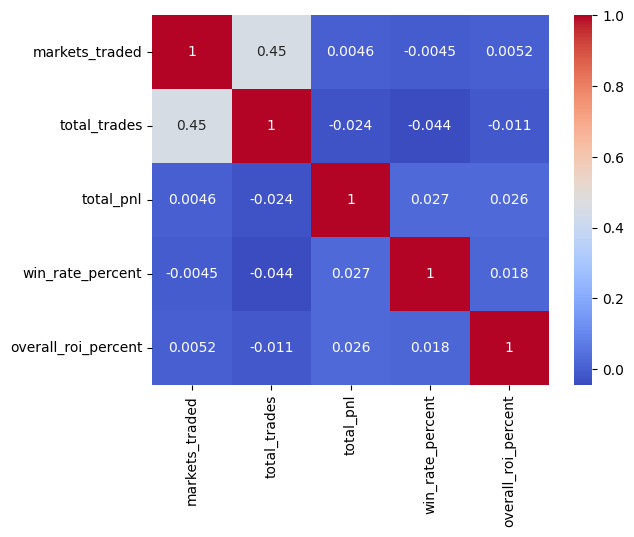

In [ ]:
# look at correlation between columns
corr_cols = ['markets_traded', 'total_trades', 'total_pnl','win_rate_percent', 'overall_roi_percent']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')

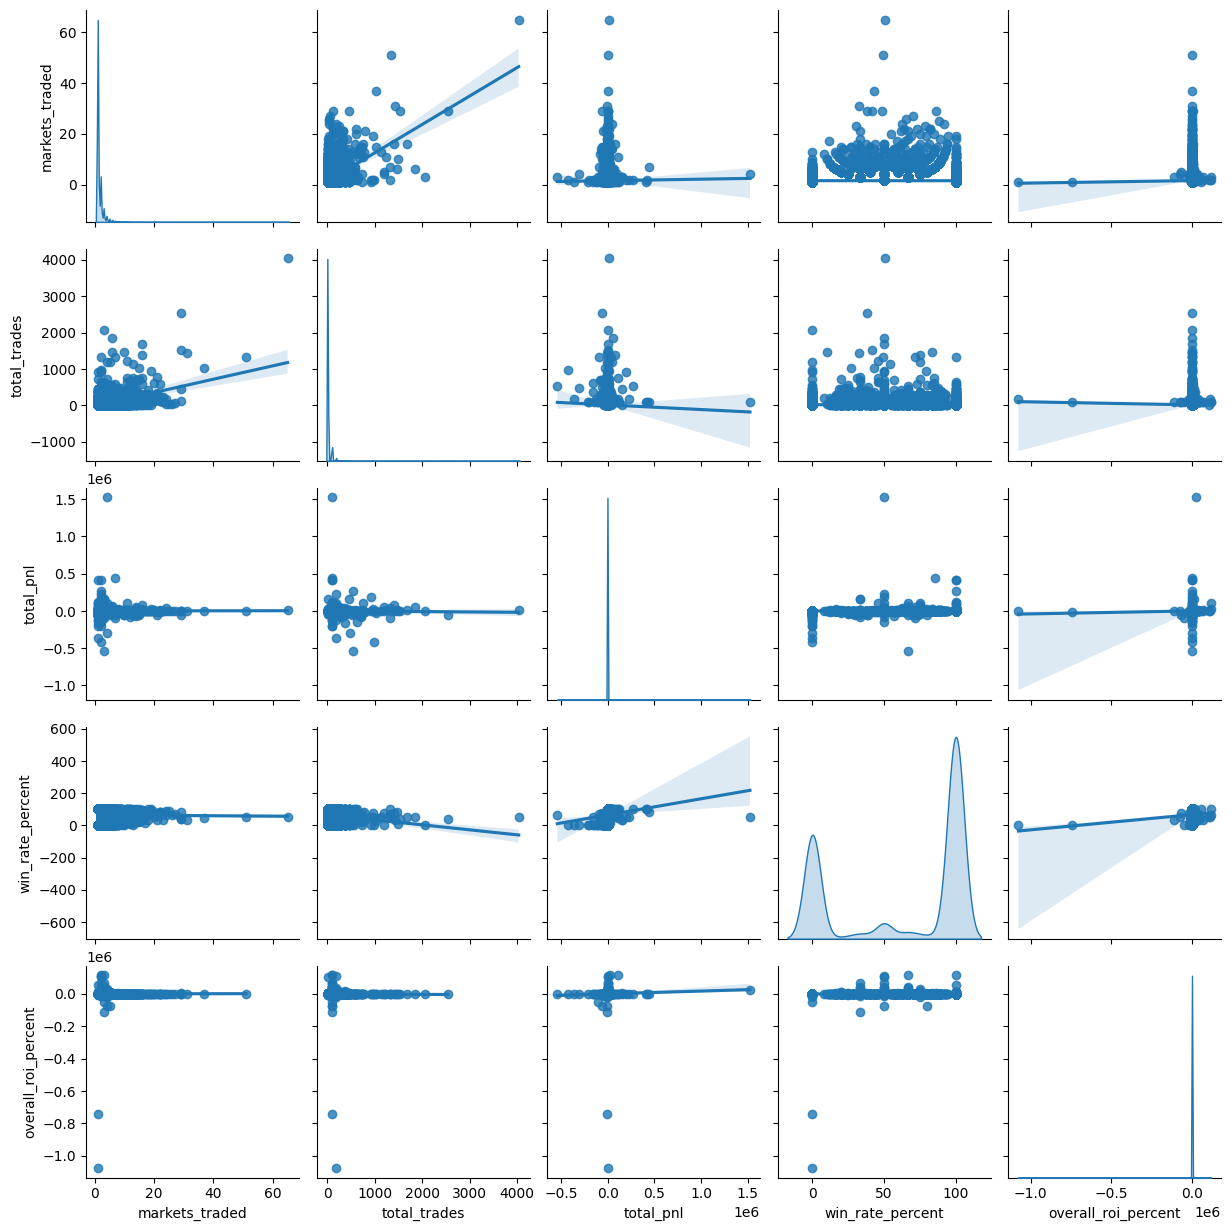

In [34]:
sns.pairplot(df[corr_cols], kind='reg', diag_kind='kde')

In [56]:
df.sort_values(by='overall_roi_percent', ascending=False).head(10)

,proxy_wallet,markets_traded,total_trades,total_shares_bought,total_shares_sold,total_pnl,avg_pnl_per_market,max_pnl_market,min_pnl_market,total_invested,total_proceeds,total_position_value,profitable_markets,losing_markets,breakeven_markets,win_rate_percent,overall_roi_percent,calculated_at
9835,0x5858196bbcb5059a7f67904deb06755dc2adfbbf,3,92,100.000000,244223.42,109040.686957,36346.895652,109066.006026,-30.519069,94.800000,110924.006957,-1788.520,2,1,0,66.666667,115021.821685,2025-12-14T21:13:08.690951+00:00
26319,0xeaa7fbf2766898d731d0ce5f3a3e1e643051922e,2,91,25.000000,61960.50,22930.385000,11465.192500,22925.385000,5.000000,20.000000,22925.385000,25.000,2,0,0,100.000000,114651.925000,2025-12-14T21:13:08.690951+00:00
19294,0xac1b85752b80065a09780d1d7d3c2aa0420c92de,2,181,300.000000,49500.00,1290.300000,645.150000,1291.500000,-1.200000,1.200000,1291.500000,0.000,1,1,0,50.000000,107525.000000,2025-12-14T21:13:08.690951+00:00
18220,0xa2c3bf82e7a7756ba341ec61f0656b8928fd5d9d,2,3,1000.000000,6127.29,1022.609627,511.304813,1023.609627,-1.000000,1.000000,1023.609627,0.000,1,1,0,50.000000,102260.962664,2025-12-14T21:13:08.690951+00:00
14681,0x8320691a96ec7d94fe72e5d5ec22831739ca94eb,3,94,15.625000,127296.32,1373.233828,457.744609,1374.403728,-0.887500,2.000000,1375.233828,0.000,1,2,0,33.333333,68661.691377,2025-12-14T21:13:08.690951+00:00
24473,0xdacfa3a59db15ad899db519c83212451b15e8d11,2,92,238.095238,75006.49,6728.215420,3364.107710,6729.156000,-0.940580,10.000000,6738.215420,0.000,1,1,0,50.000000,67282.154224,2025-12-14T21:13:08.690951+00:00
2533,0x163c77c2b44fb451acfe77bbabf4ac5e0709d438,1,91,1000.000000,262980.00,524.960000,524.960000,524.960000,524.960000,1.000000,525.960000,0.000,1,0,0,100.000000,52496.000000,2025-12-14T21:13:08.690951+00:00
18779,0xa79438348af0efae79d2e9b4e4f531e549d8e7d8,3,92,127.538250,8900.29,2208.518264,736.172755,2214.252004,-5.000001,5.000001,2448.608264,-235.090,1,2,0,33.333333,44170.359749,2025-12-14T21:13:08.690951+00:00
27067,0xf19e12c183da1fc57e1962587bbc3a2e0a708eaa,3,93,1.006000,44372.03,423.875026,141.291675,415.377000,-0.001964,0.999964,424.868990,0.006,2,1,0,66.666667,42389.028605,2025-12-14T21:13:08.690951+00:00
19066,0xa9e486c6b197e1680e715fa2f9f0ba07d5d7b6ad,2,92,58.823529,5077.22,401.060200,200.530100,401.472000,-0.411800,1.000000,402.060200,0.000,1,1,0,50.000000,40106.020281,2025-12-14T21:13:08.690951+00:00


In [57]:
df.columns

Index(['proxy_wallet', 'markets_traded', 'total_trades', 'total_shares_bought',
       'total_shares_sold', 'total_pnl', 'avg_pnl_per_market',
       'max_pnl_market', 'min_pnl_market', 'total_invested', 'total_proceeds',
       'total_position_value', 'profitable_markets', 'losing_markets',
       'breakeven_markets', 'win_rate_percent', 'overall_roi_percent',
       'calculated_at'],
      dtype='object')


PCA Explained Variance: [0.78446026 0.20236937]
Total variance explained: 98.68%


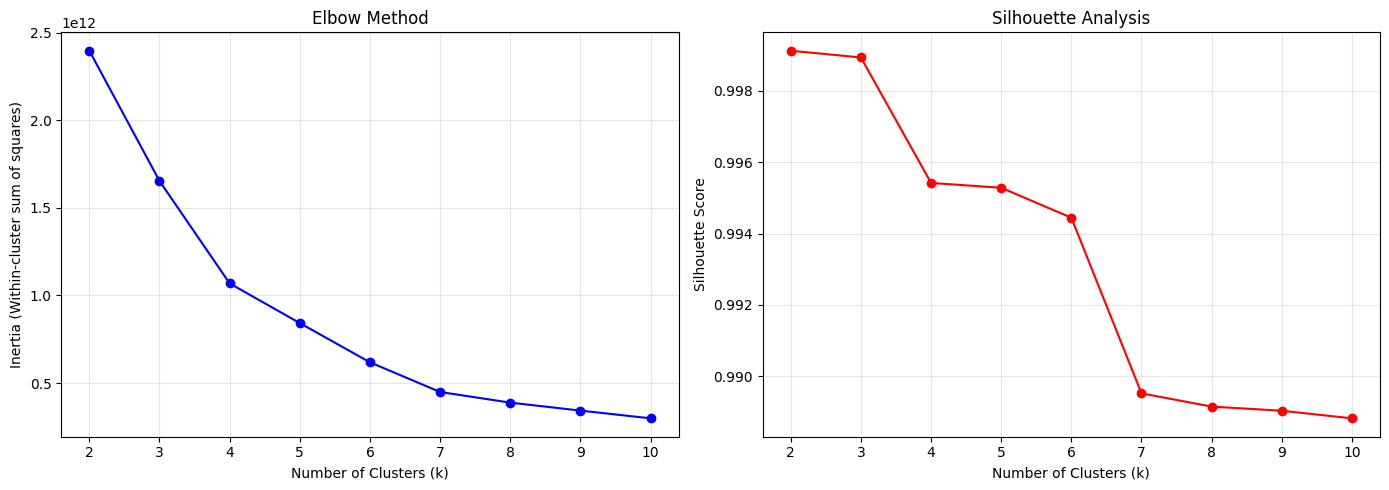

In [70]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Select features for clustering
feature_cols = [
    'markets_traded', 'total_trades', 'total_shares_bought',
    'total_shares_sold', 'total_pnl', 'avg_pnl_per_market',
    #'max_pnl_market', 'min_pnl_market', 'total_invested', 
    #'total_proceeds', 'total_position_value', 'profitable_markets', 
    #'losing_markets', 'breakeven_markets',
    'win_rate_percent', 'overall_roi_percent'
]

# Create a copy and handle missing values
df_cluster = df.copy()
df_cluster = df_cluster.dropna(subset=feature_cols) 

# Option A: StandardScaler (good for normally distributed data)

# Option B: RobustScaler (better for data with outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_cluster[feature_cols])
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_cluster.index)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA Explained Variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


# use elbow method to determine the optimal number of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# print("\nSilhouette Scores:")
# for k, score in zip(K_range, silhouette_scores):
#     print(f"k={k}: {score:.3f}")


K-Means Clustering (k=7):

Cluster sizes:
cluster_kmeans
0    25005
1        1
2        1
3       45
4        8
5        6
6        8
Name: count, dtype: int64
markets_traded            1.599080
total_trades             15.194201
total_shares_bought    6008.012756
total_shares_sold       638.579550
total_pnl               -23.167705
avg_pnl_per_market      -19.411581
win_rate_percent         67.321626
overall_roi_percent     -59.639712

🎯 Key Metrics:
  Avg Total PNL: $-23.17
  Avg Win Rate: 67.3%
  Avg ROI: -59.6%
  Avg Markets Traded: 1.6
markets_traded         3.000000e+00
total_trades           9.500000e+01
total_shares_bought    4.435897e+03
total_shares_sold      8.957206e+06
total_pnl              1.824192e+04
avg_pnl_per_market     6.080640e+03
win_rate_percent       6.666667e+01
overall_roi_percent    1.628743e+04

🎯 Key Metrics:
  Avg Total PNL: $18241.92
  Avg Win Rate: 66.7%
  Avg ROI: 16287.4%
  Avg Markets Traded: 3.0
markets_traded         4.000000e+00
total_trades     

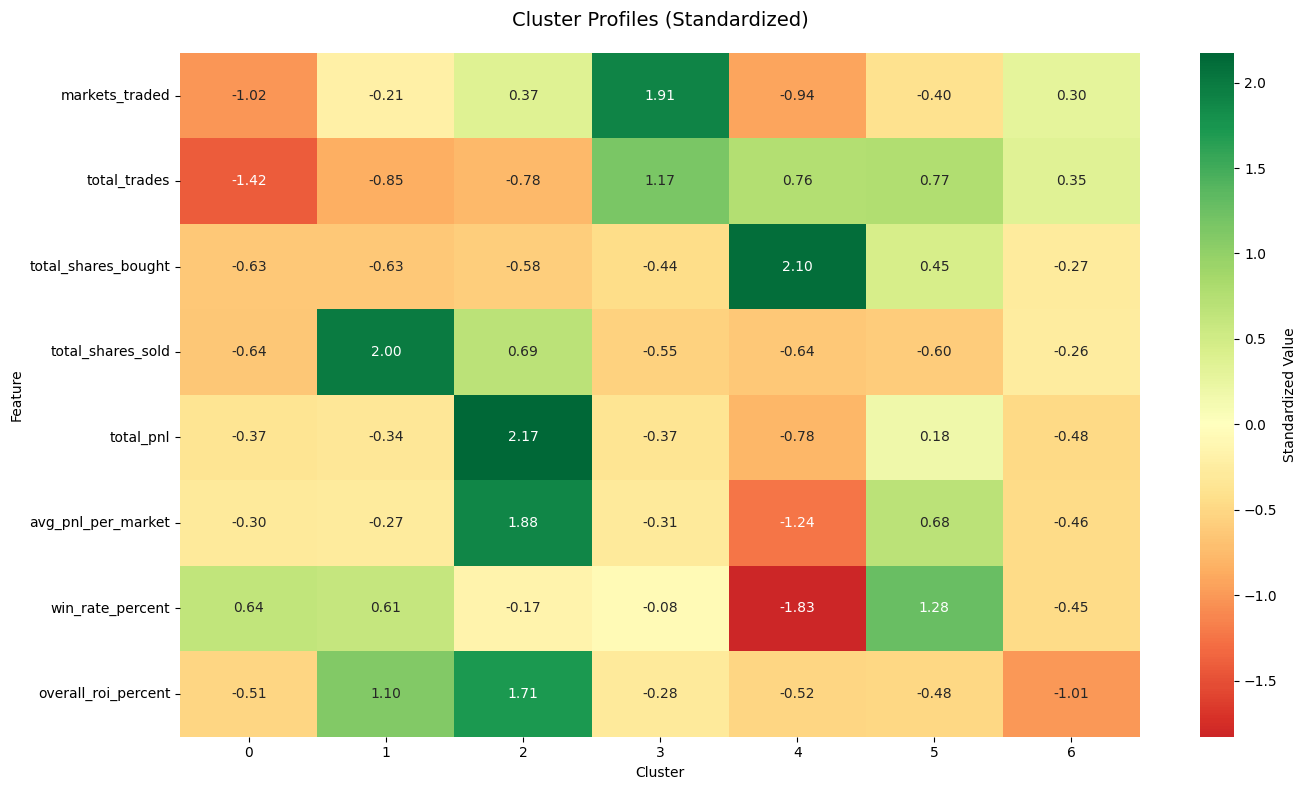


✅ Clustering complete!
Added 'cluster' column to dataframe


In [71]:
# kmeans clustering
optimal_k = 7

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means Clustering (k={optimal_k}):")
print(f"\nCluster sizes:")
print(df_cluster['cluster_kmeans'].value_counts().sort_index())

# ============================================================================
# 6. HIERARCHICAL CLUSTERING
# ============================================================================

# Compute linkage
# linkage_matrix = linkage(X_scaled, method='ward')

# # Plot dendrogram
# plt.figure(figsize=(12, 6))
# dendrogram(linkage_matrix, no_labels=True)
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('User Index')
# plt.ylabel('Distance')
# plt.axhline(y=50, color='r', linestyle='--', label='Cut threshold')  # Adjust threshold
# plt.legend()
# plt.show()

# # Apply hierarchical clustering
# hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
# df_cluster['cluster_hierarchical'] = hierarchical.fit_predict(X_scaled)

# ============================================================================
# 7. DBSCAN (Density-based clustering)
# ============================================================================

# DBSCAN - automatically determines number of clusters
# dbscan = DBSCAN(eps=3, min_samples=5)  # Tune eps and min_samples
# df_cluster['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

# print(f"\nDBSCAN Clustering:")
# print(f"Number of clusters: {len(set(df_cluster['cluster_dbscan'])) - (1 if -1 in df_cluster['cluster_dbscan'] else 0)}")
# print(f"Noise points: {sum(df_cluster['cluster_dbscan'] == -1)}")
# print(f"\nCluster sizes:")
# print(df_cluster['cluster_dbscan'].value_counts().sort_index())

# ============================================================================
# 8. VISUALIZATION
# ============================================================================

# Plot clusters in PCA space
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # K-Means
# scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
#                            c=df_cluster['cluster_kmeans'], 
#                            cmap='viridis', alpha=0.6, s=50)
# axes[0].set_title(f'K-Means Clustering (k={optimal_k})')
# axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
# axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
# plt.colorbar(scatter1, ax=axes[0])

# # Hierarchical
# scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], 
#                            c=df_cluster['cluster_hierarchical'], 
#                            cmap='viridis', alpha=0.6, s=50)
# axes[1].set_title('Hierarchical Clustering')
# axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
# axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
# plt.colorbar(scatter2, ax=axes[1])

# # DBSCAN
# scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], 
#                            c=df_cluster['cluster_dbscan'], 
#                            cmap='viridis', alpha=0.6, s=50)
# axes[2].set_title('DBSCAN Clustering')
# axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
# axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
# plt.colorbar(scatter3, ax=axes[2])

# plt.tight_layout()
# plt.show()

# ============================================================================
# 9. CLUSTER PROFILING (Interpret what each cluster represents)
# ============================================================================

# Profile clusters using K-Means result
for cluster_id in sorted(df_cluster['cluster_kmeans'].unique()):
    cluster_data = df_cluster[df_cluster['cluster_kmeans'] == cluster_id]
    
    # Show mean values for each feature
    profile = cluster_data[feature_cols].mean()
    print(profile.to_string())
    
    # Key characteristics
    print(f"\n🎯 Key Metrics:")
    print(f"  Avg Total PNL: ${profile['total_pnl']:.2f}")
    print(f"  Avg Win Rate: {profile['win_rate_percent']:.1f}%")
    print(f"  Avg ROI: {profile['overall_roi_percent']:.1f}%")
    print(f"  Avg Markets Traded: {profile['markets_traded']:.1f}")

# ============================================================================
# 10. CLUSTER COMPARISON HEATMAP
# ============================================================================

# Create cluster profile comparison
cluster_profiles = df_cluster.groupby('cluster_kmeans')[feature_cols].mean()

# Normalize for better visualization
cluster_profiles_normalized = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles_normalized.T, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlGn', 
            center=0,
            cbar_kws={'label': 'Standardized Value'})
plt.title('Cluster Profiles (Standardized)', fontsize=14, pad=20)
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ============================================================================
# 11. SAVE RESULTS
# ============================================================================

# Add cluster labels back to original dataframe
df['cluster'] = df_cluster['cluster_kmeans']

# Save clustered data
# df_cluster.to_csv('users_clustered.csv', index=False)

print("\n✅ Clustering complete!")
print(f"Added 'cluster' column to dataframe")

In [74]:
df_cluster[df_cluster['cluster_kmeans'] == 6]

,proxy_wallet,markets_traded,total_trades,total_shares_bought,total_shares_sold,total_pnl,avg_pnl_per_market,max_pnl_market,min_pnl_market,total_invested,total_proceeds,total_position_value,profitable_markets,losing_markets,breakeven_markets,win_rate_percent,overall_roi_percent,calculated_at,cluster,cluster_kmeans
615,0x052c6312a485d494f4b0b0bed1b834c09bd85a0e,3,100,200.000000,1326609.28,-101444.110262,-33814.703421,-667.016303,-99286.301605,196.400000,1.225162e+06,-1.326409e+06,0,3,0,0.000000,-51651.787303,2025-12-14T21:13:08.690951+00:00,3.0,6
1118,0x09d5f3dc4694bc5ee025167715b60aa61f836f79,2,91,2557.246152,1344461.40,2659.052810,1329.526405,2688.922800,-29.869990,29.869990,2.688923e+03,0.000000e+00,1,1,0,50.000000,8902.087930,2025-12-14T21:13:08.690951+00:00,0.0,6
1518,0x0d4e0a89b6cd67fd965921e925b8aae02f647196,1,270,143277.210000,2163950.10,43788.781705,43788.781705,43788.781705,43788.781705,10799.999682,5.458878e+04,0.000000e+00,1,0,0,100.000000,405.451694,2025-12-14T21:13:08.690951+00:00,4.0,6
8858,0x4f5e6216719c7347caf4dc42cf49013ce4671773,12,197,12314.070756,1126372.50,-5155.342395,-429.611866,2252.745000,-7560.000000,10722.158151,2.252745e+03,3.314071e+03,11,1,0,91.666667,-48.081201,2025-12-14T21:13:08.690951+00:00,0.0,6
15740,0x8c7b26969470bd87494b5d406c3e84256d102a87,4,96,2982.160000,843697.33,9110.933481,2277.733370,9571.187216,-457.502975,457.502975,9.779986e+03,-2.115500e+02,2,2,0,50.000000,1991.447922,2025-12-14T21:13:08.690951+00:00,0.0,6
23477,0xd189664c5308903476f9f079820431e4fd7d06f4,5,191,59953.290000,1074693.80,-3124.128110,-624.825622,13.964990,-3145.033410,59863.336710,1.071480e+06,-1.014741e+06,3,2,0,60.000000,-5.218767,2025-12-14T21:13:08.690951+00:00,3.0,6
24659,0xdc31956b01f12e6b2778dde4e0027d11aca8c181,2,182,961707.326670,961706.85,-40780.072652,-20390.036326,-764.062682,-40016.009970,90999.997671,5.021993e+04,0.000000e+00,0,2,0,0.000000,-44.813268,2025-12-14T21:13:08.690951+00:00,0.0,6
27649,0xf705fa045201391d9632b7f3cde06a5e24453ca7,2,973,364727.900000,1500599.12,-423038.812510,-211519.406255,-39879.230000,-383159.582509,235270.951313,1.024896e+06,-1.212664e+06,0,2,0,0.000000,-179.809199,2025-12-14T21:13:08.690951+00:00,3.0,6
